# Week iV: image classification and OCR

In this week's lesson we're going to begin exploring the field of computer vision, and see how deep learning can help us solve problems in this field. We'll begin by building a neural network for image classification. We'll examine convolutional vs. fully-connected architectures, and see the adverse effect of noise on DL models.

## MNIST Dataset

The MNIST dataset is one of the most common datasets for image classifcation. It contains 70,000 samples of handwritten digits ranging from 0 to 9. The goal is to correctly recognize the handwritten digit. Here are a few examples taken from the original database:
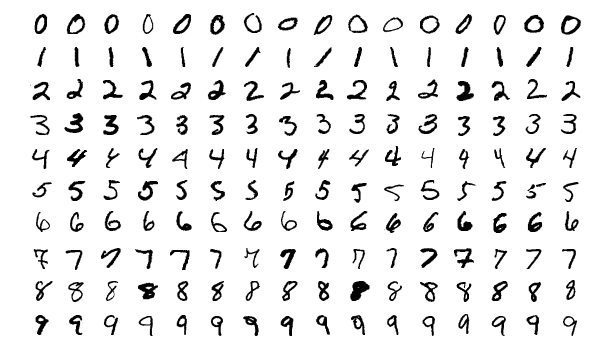

Let's begin by getting the data, using Keras. Keras already split the data into train vs. test and samples vs. labels for us:

In [1]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

We'll continue by exploring the data.

In [2]:
print('Shape of x_train is:', x_train.shape)
print('Shape of y_train is:', y_train.shape)
print('Shape of x_test is:', x_test.shape)
print('Shape of y_test is:', y_test.shape)

Shape of x_train is: (60000, 28, 28)
Shape of y_train is: (60000,)
Shape of x_test is: (10000, 28, 28)
Shape of y_test is: (10000,)


In [3]:
assert x_train.shape == (60000, 28, 28)

We can see that each sample is an image of size 28X28 pixels.

In [4]:
import numpy as np
np.min(x_train), np.max(x_train), x_train.dtype

(0, 255, dtype('uint8'))

Each pixel has integer values ranging from 0 to 255.

In [5]:
np.min(y_train), np.max(y_train), y_train.dtype

(0, 9, dtype('uint8'))

Similarly, there are 10 labels (classes) in the dataset, represented by the integers 0-9. 

Let's plot some random samples with their labels:  

<Figure size 432x288 with 0 Axes>

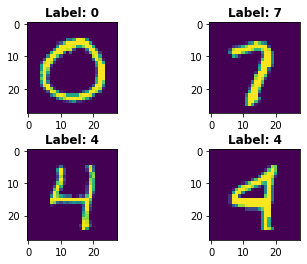

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_random_samples(x, y):
  plt.figure()

  f, axarr = plt.subplots(2, 2, gridspec_kw={'hspace':0.4}) 
  rands = np.random.randint(x.shape[0], size=4)
  axarr[0, 0].imshow(x[rands[0], :, :])
  axarr[0, 0].set_title('Label: ' + str(y[rands[0]]), fontweight='bold')

  axarr[1, 0].imshow(x[rands[1], :, :])
  axarr[1, 0].set_title('Label: ' + str(y[rands[1]]), fontweight='bold')

  axarr[0, 1].imshow(x[rands[2], :, :])
  axarr[0, 1].set_title('Label: ' + str(y[rands[2]]), fontweight='bold')

  axarr[1, 1].imshow(x[rands[3], :, :])
  axarr[1, 1].set_title('Label: ' + str(y[rands[3]]), fontweight='bold')

  plt.show()

plot_random_samples(x_train, y_train)

Image data should often be scaled in some way to improve the convergence of the neural network. The two most common ways are to normalize the data to a Gaussian distribution, or to normalize it by dividing the data with the maximal value. We'll be using the latter method:

In [7]:
x_train = x_train / 255.0
x_test = x_test / 255.0

Note that both training and testing sets must be normalized in the same way!

Let's check how the normalization changed the data:

In [8]:
np.min(x_train), np.max(x_train), x_train.dtype

(0.0, 1.0, dtype('float64'))

We see that the min value stayed 0, while the max value is now 1. Also, the data is now of type 'float' and not 'int'.

We'll plot some samples again to make sure the shape of the images in the data did not change:

<Figure size 432x288 with 0 Axes>

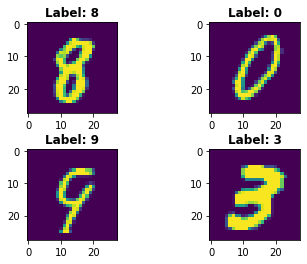

In [9]:
plot_random_samples(x_train, y_train)

Finally, we'll split the training data into training vs validation:

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1/6)

We chose 1/6 as the split ratio to keep the valdiation and testing sets the same size. After this split we should have 50k training samples, 10k testing, and 10 k validation: 

In [11]:
print('Shape of x_train is:', x_train.shape)
print('Shape of y_train is:', y_train.shape)
print('Shape of x_test is:', x_test.shape)
print('Shape of y_test is:', y_test.shape)
print('Shape of x_val is:', x_val.shape)
print('Shape of y_val is:', y_val.shape)

Shape of x_train is: (50000, 28, 28)
Shape of y_train is: (50000,)
Shape of x_test is: (10000, 28, 28)
Shape of y_test is: (10000,)
Shape of x_val is: (10000, 28, 28)
Shape of y_val is: (10000,)


We'll also change the labels to a one-hot format, such that each label is a sparse vector representing the correct class:

In [12]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

And their new shape should be (#num of samples, 10):

In [13]:
print('Shape of y_train is:', y_train.shape)
print('Shape of y_test is:', y_test.shape)
print('Shape of y_val is:', y_val.shape)
print(y_train[0, :])

Shape of y_train is: (50000, 10)
Shape of y_test is: (10000, 10)
Shape of y_val is: (10000, 10)
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


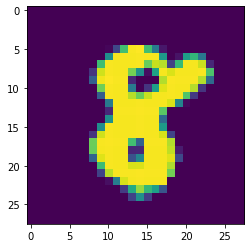

In [14]:
plt.imshow(x_train[0])

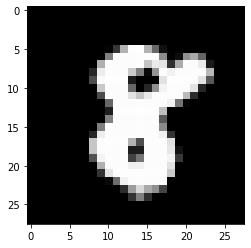

In [15]:
plt.imshow(x_train[0], cmap='gray')

Finally, an image neural network expects a channel dimension. In our case we're dealing with a grayscale so the channel does not have a physical interpretation. We'll artificially increse the dimensions of the X-datasets:

In [16]:
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
print('Shape of x_train is:', x_train.shape)
print('Shape of x_test is:', x_test.shape)
print('Shape of x_val is:', x_val.shape)

Shape of x_train is: (50000, 28, 28, 1)
Shape of x_test is: (10000, 28, 28, 1)
Shape of x_val is: (10000, 28, 28, 1)


## Building a neural network

Now that we've finished the preprocessing phase, we can move along and begin designing a neural network. We'll start with a very simple shallow fully-connected architecture.

We'll use the Keras Sequential API:


In [17]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

model = Sequential()

We'll begin with an input layer that flattens every image. Since this is the first layer in a Sequential model, we must specify the input shape:

In [18]:
model.add(Flatten(input_shape=(28, 28, 1)))

We'll add a single fully-connected hidden layer with 128 neurons and a ReLU activation:

In [19]:
model.add(Dense(128, activation='relu'))

We'll finish the architecture with a final output (or prediction) layer. Since we have 10 different classes, we want the output of the network to be a vector of size 10 with the probabilities of each class. Hence, softmax is the fitting choice for activation:

In [20]:
model.add(Dense(10, activation='softmax'))

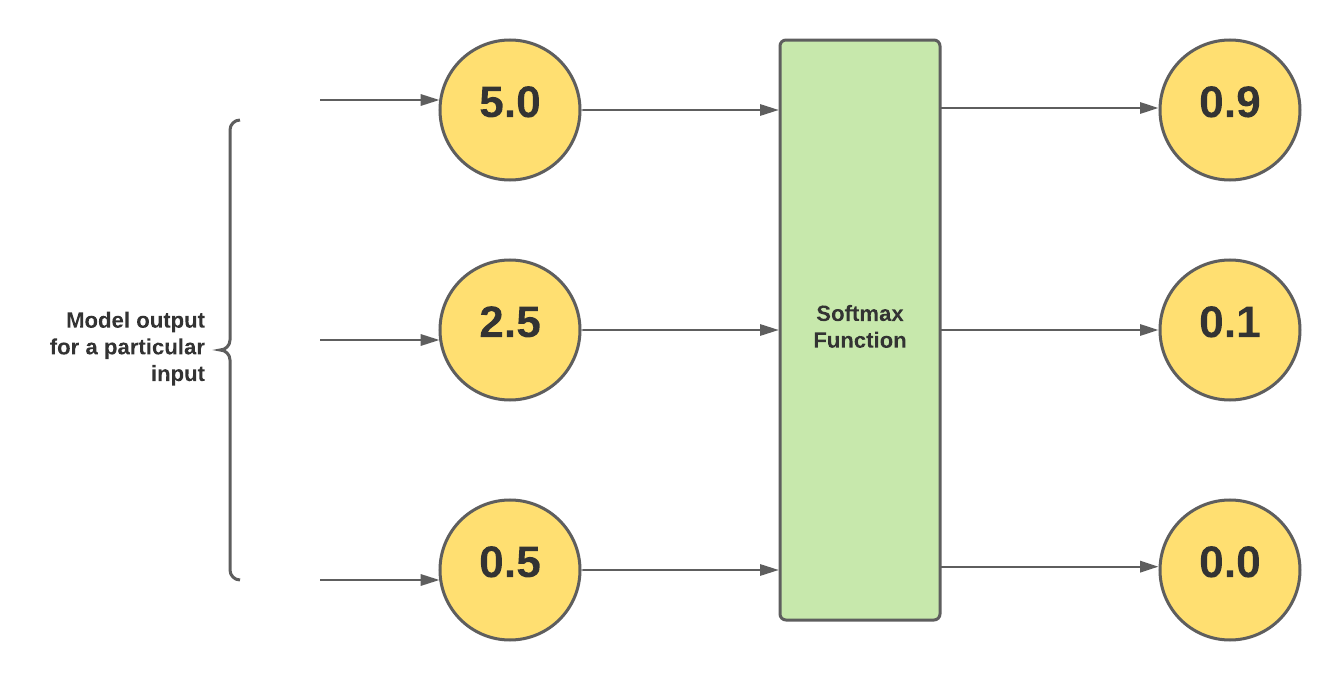

https://vitalflux.com/what-softmax-function-why-needed-machine-learning/

This is our model:

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


Since this is a classification proble, we'll use the cross entropy (NLL) loss:

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=256, epochs=10)

Epoch 1/10
196/196 [==============================] - 2s 5ms/step - loss: 0.4872 - accuracy: 0.8691 - val_loss: 0.2572 - val_accuracy: 0.9279
Epoch 2/10
196/196 [==============================] - 1s 4ms/step - loss: 0.2159 - accuracy: 0.9391 - val_loss: 0.1922 - val_accuracy: 0.9440
Epoch 3/10
196/196 [==============================] - 1s 4ms/step - loss: 0.1641 - accuracy: 0.9534 - val_loss: 0.1599 - val_accuracy: 0.9515
Epoch 4/10
196/196 [==============================] - 1s 4ms/step - loss: 0.1353 - accuracy: 0.9615 - val_loss: 0.1430 - val_accuracy: 0.9567
Epoch 5/10
196/196 [==============================] - 1s 4ms/step - loss: 0.1127 - accuracy: 0.9682 - val_loss: 0.1269 - val_accuracy: 0.9609
Epoch 6/10
196/196 [==============================] - 1s 3ms/step - loss: 0.0960 - accuracy: 0.9732 - val_loss: 0.1165 - val_accuracy: 0.9644
Epoch 7/10
196/196 [==============================] - 1s 4ms/step - loss: 0.0831 - accuracy: 0.9763 - val_loss: 0.1066 - val_accuracy: 0.9659
Epoch 

## Testing the model

Let's run the model on the testing data:

In [23]:
y_pred = model.predict(x_test)

313/313 [==============================] - 1s 1ms/step


Each output is a vector of size 10: 

In [24]:
y_pred.shape

(10000, 10)

In [25]:
y_pred[0]

array([5.2415771e-07, 1.3681330e-08, 5.2539192e-05, 5.4453756e-04,
       6.9524568e-09, 1.4537426e-07, 1.7830378e-12, 9.9939871e-01,
       8.8277727e-07, 2.6490002e-06], dtype=float32)

Let's look at the larget value for each sample (the predicted class):

In [26]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

In [27]:
y_pred_labels[0]

7

And now we can compute the model's confusion matrix:

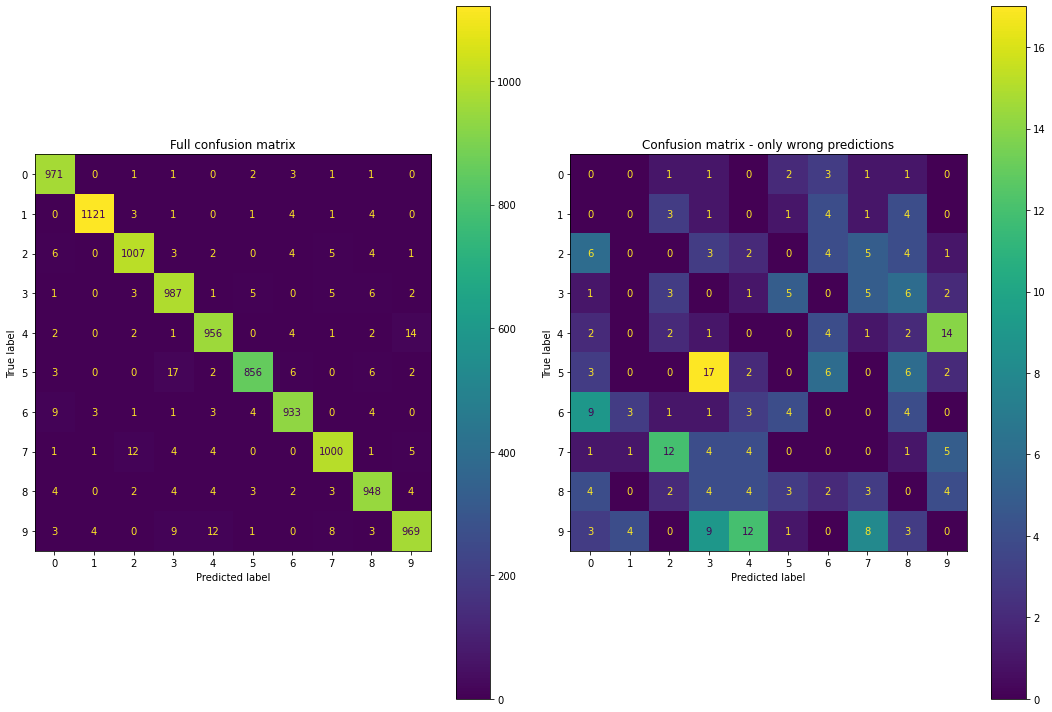

In [28]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

martix = confusion_matrix(y_true_labels, y_pred_labels)
ConfusionMatrixDisplay(martix).plot(ax=axes[0])
axes[0].title.set_text('Full confusion matrix')

np.fill_diagonal(martix, 0)
ConfusionMatrixDisplay(martix).plot(ax=axes[1])
axes[1].title.set_text('Confusion matrix - only wrong predictions')

plt.tight_layout()  
plt.show()

As you can see, most values are centered around the main diagonal which means our model performed well. Let's look at the accuracy:

In [29]:
from sklearn.metrics import accuracy_score
print('Accuracy: ', accuracy_score(y_true_labels, y_pred_labels))

Accuracy:  0.9748


MNIST Benchmark: 99.83

For the sake of reference, random forest achieves an accuracy of around 0.972 after extensive hyper-parameter tuning.

We can also check the area under the receiver operating characteristic Curve (ROC AUC). Note that this is a multi-class classification problem, so we need to use averaging techniques:

In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred, multi_class="ovo", average="macro")

0.9994062295402442

Finally, let's plot some of our predictions. Note that we'll need to remove the channels dimension for the plot to work:

<Figure size 432x288 with 0 Axes>

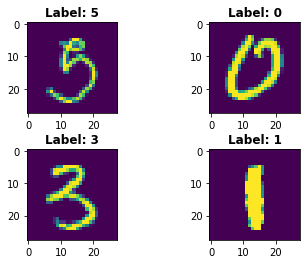

In [31]:
plot_random_samples(x_test[:, :, :, 0], y_pred_labels)

## Adversarial attacks

In real life, we often get noisy images. This is true for data in general, but noise has been studied extensively in the field of image processing. By adding noise to our previous problem we can greatly increase its difficulty.

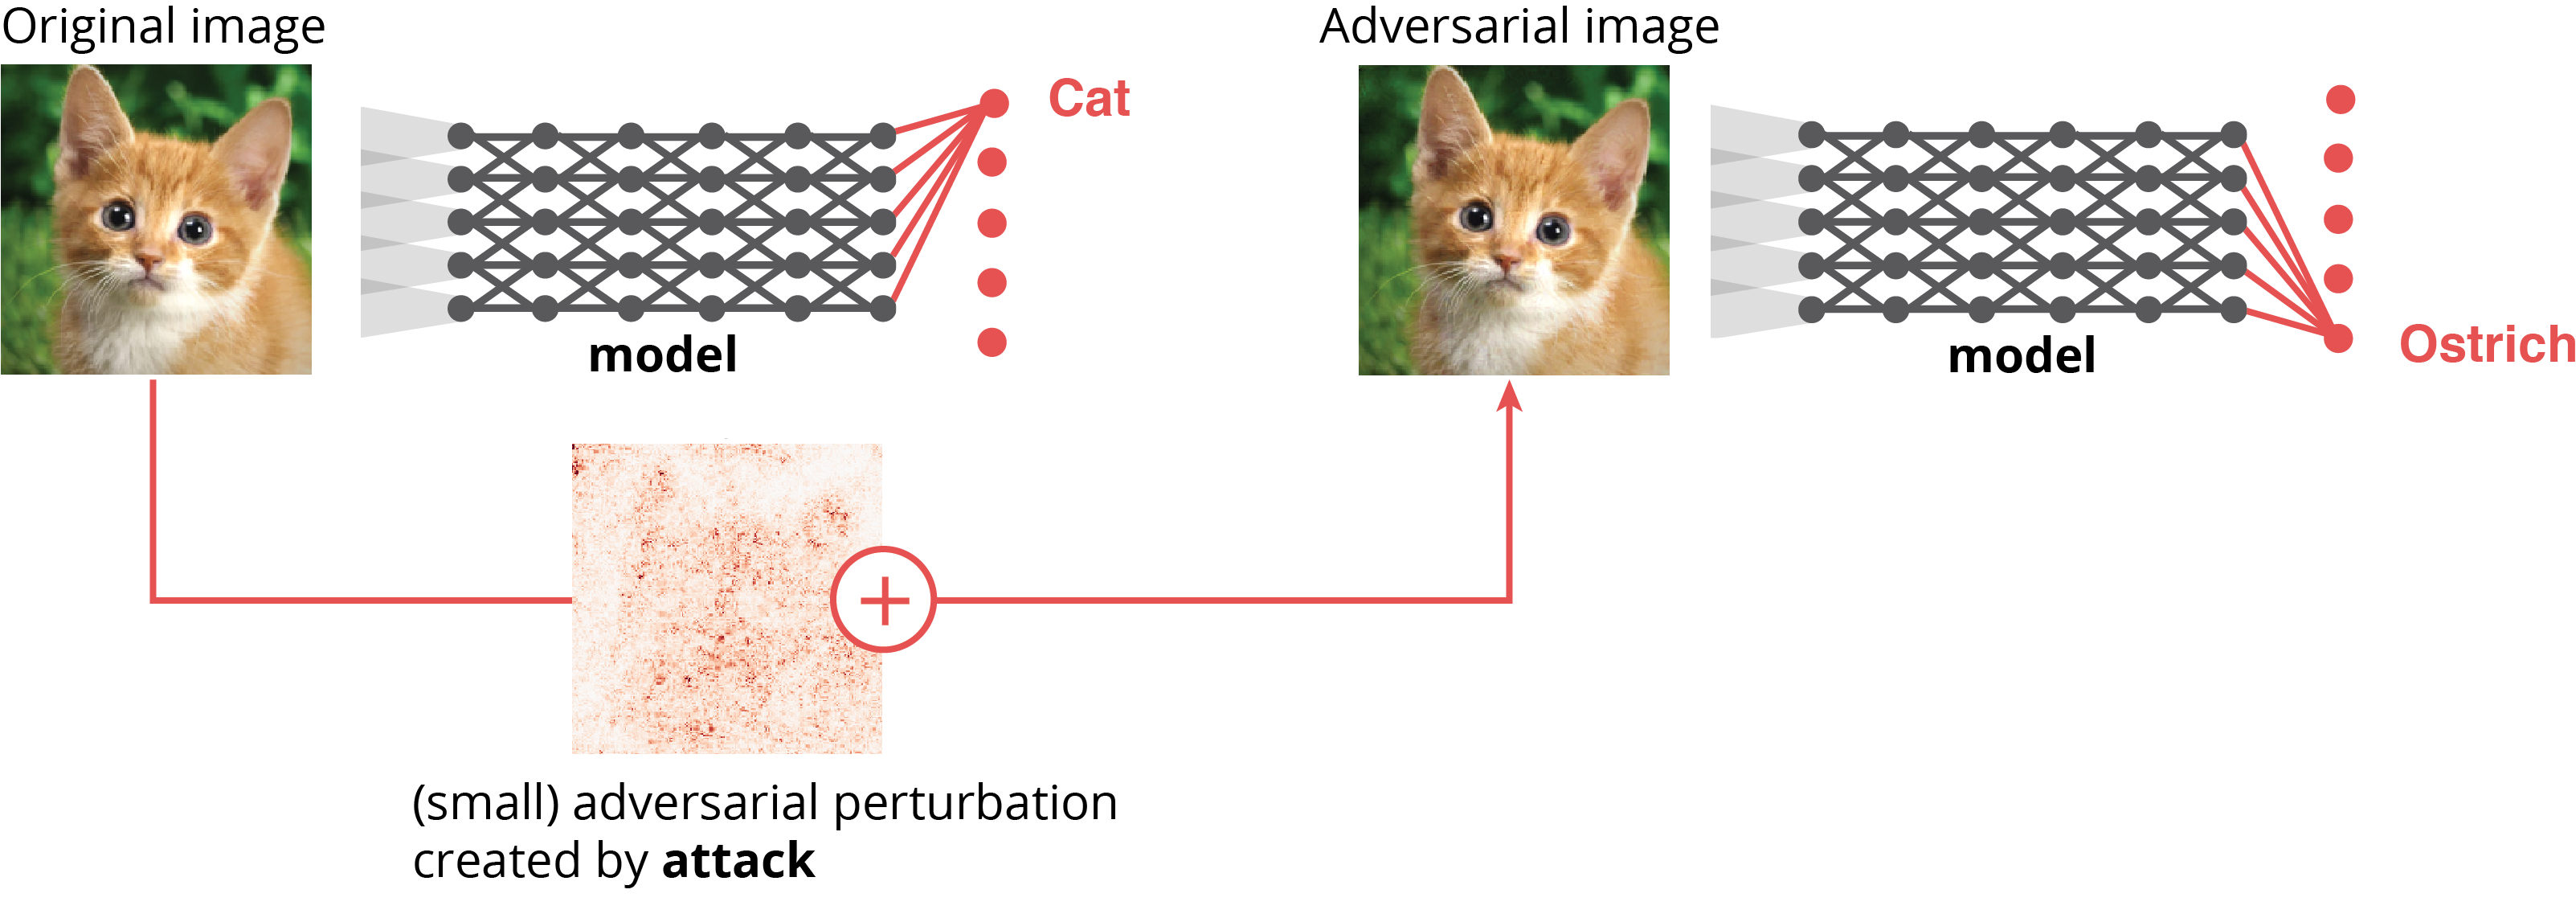

https://colab.research.google.com/drive/19N9VWTukXTPUj9eukeie55XIu3HKR5TT

### Noise: 50% 

Let's add Gaussian noise at the 50% level:

In [32]:
np.random.seed(42)
x_train_noisy = x_train + 0.5 * np.random.randn(*x_train.shape) 
x_val_noisy = x_val + 0.5 * np.random.randn(*x_val.shape) 
x_test_noisy = x_test + 0.5 * np.random.randn(*x_test.shape) 

And view some samples:

<Figure size 432x288 with 0 Axes>

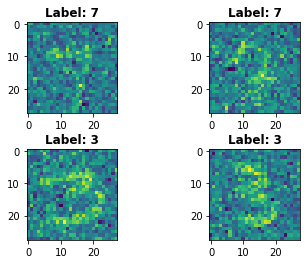

In [33]:
plot_random_samples(x_test_noisy[:, :, :, 0], y_true_labels)

Clearly, the numerals are far less identifiable now. Let's see how are model behaves:

In [34]:
y_pred_noisy = model.predict(x_test_noisy)

313/313 [==============================] - 0s 1ms/step


In [35]:
y_pred_labels_noisy = np.argmax(y_pred_noisy, axis=1)

In [36]:
print('Accuracy: ', accuracy_score(y_true_labels, y_pred_labels_noisy))

Accuracy:  0.7062


Indeed, we observe a drop in accuracy. It's understandable, since our network did not see any noisy images. Let's try to retrain the model on the noisy data:

In [37]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train_noisy, y_train, validation_data=(x_val_noisy, y_val), batch_size=256, epochs=10)

Epoch 1/10
196/196 [==============================] - 1s 4ms/step - loss: 0.5392 - accuracy: 0.8438 - val_loss: 0.3840 - val_accuracy: 0.8807
Epoch 2/10
196/196 [==============================] - 1s 4ms/step - loss: 0.2556 - accuracy: 0.9191 - val_loss: 0.3340 - val_accuracy: 0.8968
Epoch 3/10
196/196 [==============================] - 1s 3ms/step - loss: 0.1749 - accuracy: 0.9471 - val_loss: 0.3163 - val_accuracy: 0.9033
Epoch 4/10
196/196 [==============================] - 1s 4ms/step - loss: 0.1254 - accuracy: 0.9645 - val_loss: 0.3096 - val_accuracy: 0.9070
Epoch 5/10
196/196 [==============================] - 1s 4ms/step - loss: 0.0896 - accuracy: 0.9790 - val_loss: 0.3113 - val_accuracy: 0.9081
Epoch 6/10
196/196 [==============================] - 1s 4ms/step - loss: 0.0638 - accuracy: 0.9884 - val_loss: 0.3181 - val_accuracy: 0.9074
Epoch 7/10
196/196 [==============================] - 1s 4ms/step - loss: 0.0448 - accuracy: 0.9945 - val_loss: 0.3238 - val_accuracy: 0.9099
Epoch 

In [38]:
y_pred_noisy = model.predict(x_test_noisy)

313/313 [==============================] - 1s 1ms/step


In [39]:
y_pred_labels_noisy = np.argmax(y_pred_noisy, axis=1)

In [40]:
print('Accuracy: ', accuracy_score(y_true_labels, y_pred_labels_noisy))

Accuracy:  0.9123


And the results greatly improved.

### Noise: 100% 

Let's add even more noise:

In [41]:
np.random.seed(42)
x_train_noisy = x_train + 1 * np.random.randn(*x_train.shape) 
x_val_noisy = x_val + 1 * np.random.randn(*x_val.shape) 
x_test_noisy = x_test + 1 * np.random.randn(*x_test.shape) 

<Figure size 432x288 with 0 Axes>

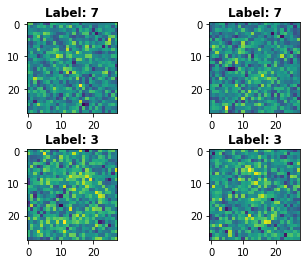

In [42]:
plot_random_samples(x_test_noisy[:, :, :, 0], y_true_labels)

The numerals are barely recognizable at this point.

In [43]:
y_pred_noisy = model.predict(x_test_noisy)

313/313 [==============================] - 0s 2ms/step


In [44]:
y_pred_labels_noisy = np.argmax(y_pred_noisy, axis=1)

In [45]:
print('Accuracy: ', accuracy_score(y_true_labels, y_pred_labels_noisy))

Accuracy:  0.6796


And our model does not perform well at all. Let's retrain it on the new noisy data:

In [46]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train_noisy, y_train, validation_data=(x_val_noisy, y_val), batch_size=256, epochs=10)

Epoch 1/10
196/196 [==============================] - 1s 4ms/step - loss: 0.6156 - accuracy: 0.8075 - val_loss: 1.3105 - val_accuracy: 0.7358
Epoch 2/10
196/196 [==============================] - 1s 4ms/step - loss: 0.3027 - accuracy: 0.8928 - val_loss: 1.2815 - val_accuracy: 0.7385
Epoch 3/10
196/196 [==============================] - 1s 4ms/step - loss: 0.1915 - accuracy: 0.9378 - val_loss: 1.2884 - val_accuracy: 0.7376
Epoch 4/10
196/196 [==============================] - 1s 3ms/step - loss: 0.1253 - accuracy: 0.9688 - val_loss: 1.3003 - val_accuracy: 0.7380
Epoch 5/10
196/196 [==============================] - 1s 4ms/step - loss: 0.0849 - accuracy: 0.9877 - val_loss: 1.3360 - val_accuracy: 0.7380
Epoch 6/10
196/196 [==============================] - 1s 4ms/step - loss: 0.0584 - accuracy: 0.9962 - val_loss: 1.3664 - val_accuracy: 0.7399
Epoch 7/10
196/196 [==============================] - 1s 4ms/step - loss: 0.0420 - accuracy: 0.9993 - val_loss: 1.4004 - val_accuracy: 0.7404
Epoch 

In [47]:
y_pred_noisy = model.predict(x_test_noisy)

313/313 [==============================] - 1s 3ms/step


In [48]:
y_pred_labels_noisy = np.argmax(y_pred_noisy, axis=1)

In [49]:
print('Accuracy: ', accuracy_score(y_true_labels, y_pred_labels_noisy))

Accuracy:  0.7476


We see an improvement, but the accuracy is still quite bad.

### Convolutional neural network

In [50]:
from IPython.display import Image
Image(url='https://media4.giphy.com/media/i4NjAwytgIRDW/giphy.gif')

Max pooling:

In [51]:
Image(url='https://nico-curti.github.io/NumPyNet/NumPyNet/images/maxpool.gif')

Nowadays, practically all computer vision neural networks utilize convolutions (and transformers, to be continued...). CNNs have the advantage of correctly identifying spatial connections and giving them extra significance. FC networks do not have this property. 

Let's build a CNN for our 100% noise problem:

In [52]:
from keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout

conv_model = Sequential()
conv_model.add(Input(shape=(28, 28, 1)))
conv_model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_model.add(Flatten())
conv_model.add(Dropout(0.5))
conv_model.add(Dense(10, activation="softmax"))

We have two convolutional layers and two max pooling layers. In the end we flatten the hidden layers' output and feed it into a final FC output layer.

In [53]:
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)             

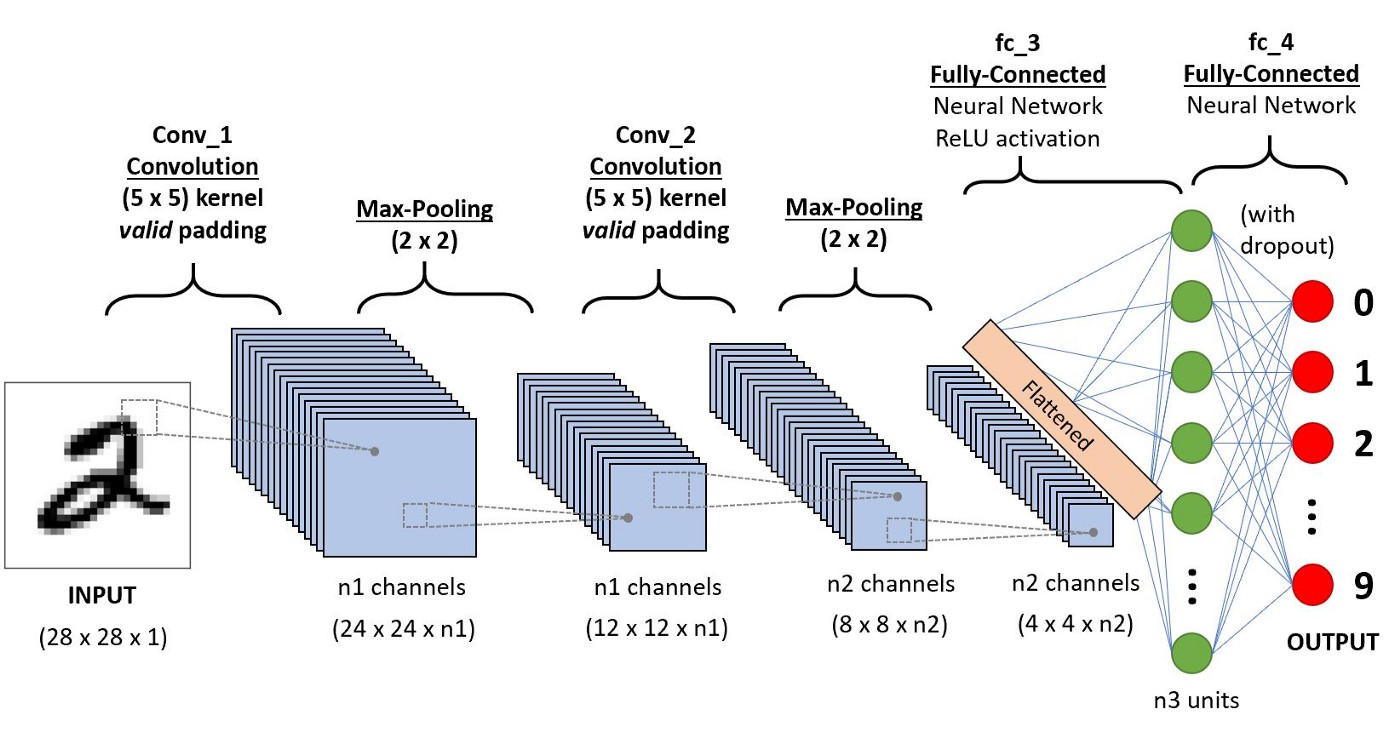

https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

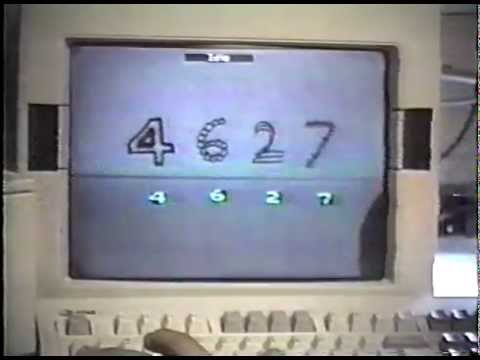

In [54]:
from IPython.display import YouTubeVideo
YouTubeVideo('FwFduRA_L6Q')

In [55]:
conv_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
conv_model.fit(x_train_noisy, y_train, validation_data=(x_val_noisy, y_val), batch_size=16, epochs=10)

Epoch 1/10
3125/3125 [==============================] - 22s 6ms/step - loss: 0.8919 - accuracy: 0.6989 - val_loss: 0.5886 - val_accuracy: 0.8049
Epoch 2/10
3125/3125 [==============================] - 12s 4ms/step - loss: 0.6904 - accuracy: 0.7691 - val_loss: 0.5643 - val_accuracy: 0.8179
Epoch 3/10
3125/3125 [==============================] - 12s 4ms/step - loss: 0.6677 - accuracy: 0.7779 - val_loss: 0.5446 - val_accuracy: 0.8155
Epoch 4/10
3125/3125 [==============================] - 11s 3ms/step - loss: 0.6556 - accuracy: 0.7803 - val_loss: 0.5236 - val_accuracy: 0.8220
Epoch 5/10
3125/3125 [==============================] - 17s 5ms/step - loss: 0.6459 - accuracy: 0.7822 - val_loss: 0.5336 - val_accuracy: 0.8196
Epoch 6/10
3125/3125 [==============================] - 16s 5ms/step - loss: 0.6392 - accuracy: 0.7858 - val_loss: 0.5353 - val_accuracy: 0.8203
Epoch 7/10
3125/3125 [==============================] - 15s 5ms/step - loss: 0.6350 - accuracy: 0.7854 - val_loss: 0.5271 - val_ac

In [56]:
y_pred_noisy = conv_model.predict(x_test_noisy)

313/313 [==============================] - 1s 2ms/step


In [57]:
y_pred_labels_noisy = np.argmax(y_pred_noisy, axis=1)

In [58]:
print('Accuracy: ', accuracy_score(y_true_labels, y_pred_labels_noisy))

Accuracy:  0.8392


In [59]:
def plot_random_samples_with_noise(x, x_noisy, y, y_pred):
  %matplotlib inline

  f, axarr = plt.subplots(4, 2, gridspec_kw={'hspace':0.4}, figsize=(18, 12), constrained_layout=True) 
  rands = np.random.randint(x.shape[0], size=4)

  axarr[0, 0].imshow(x[rands[0], :, :])
  axarr[0, 0].set_title('Real label: ' + str(y[rands[0]]), fontweight='bold')
  axarr[0, 1].imshow(x_noisy[rands[0], :, :])
  axarr[0, 1].set_title('Predicted label: ' + str(y_pred[rands[0]]), fontweight='bold')

  axarr[1, 0].imshow(x[rands[1], :, :])
  axarr[1, 0].set_title('Real label: ' + str(y[rands[1]]), fontweight='bold')
  axarr[1, 1].imshow(x_noisy[rands[1], :, :])
  axarr[1, 1].set_title('Label: ' + str(y_pred[rands[1]]), fontweight='bold')

  axarr[2, 0].imshow(x[rands[2], :, :])
  axarr[2, 0].set_title('Real label: ' + str(y[rands[2]]), fontweight='bold')
  axarr[2, 1].imshow(x_noisy[rands[2], :, :])
  axarr[2, 1].set_title('Predicted label: ' + str(y_pred[rands[2]]), fontweight='bold')

  axarr[3, 0].imshow(x[rands[3], :, :])
  axarr[3, 0].set_title('Real label: ' + str(y[rands[3]]), fontweight='bold')
  axarr[3, 1].imshow(x_noisy[rands[3], :, :])
  axarr[3, 1].set_title('Predicted label: ' + str(y_pred[rands[3]]), fontweight='bold')

  plt.show()

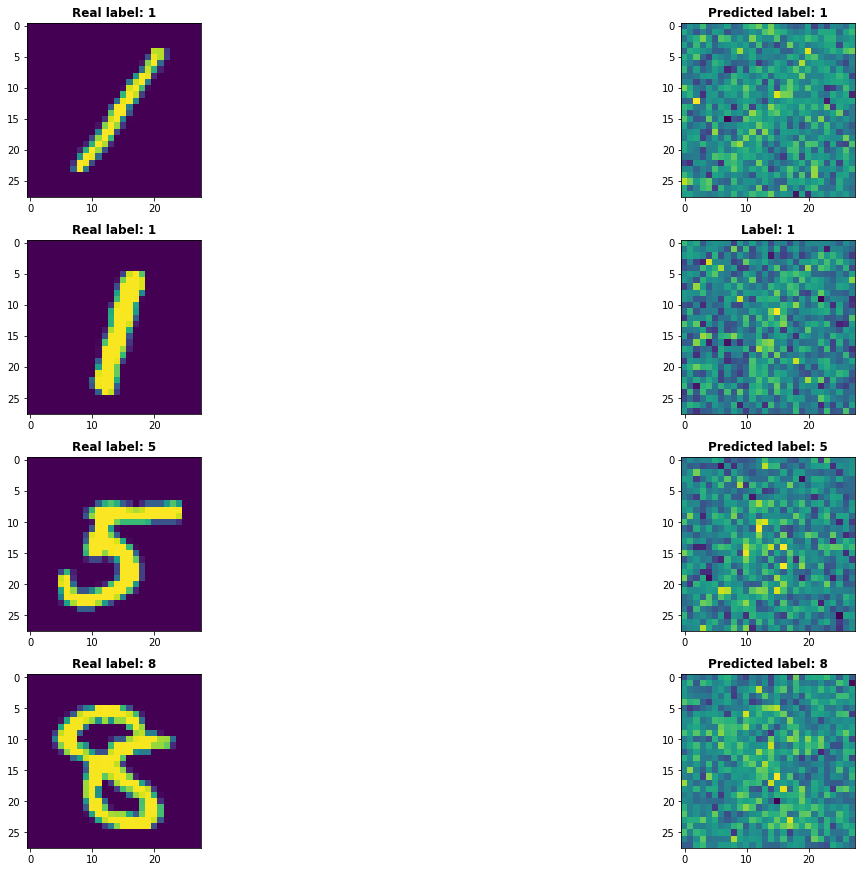

In [60]:
plot_random_samples_with_noise(x_test[:, :, :, 0], x_test_noisy[:, :, :, 0], y_true_labels, y_pred_labels_noisy)

### Predefined architecture

We'll use [Keras applications](https://keras.io/api/applications/) to load predefined models.

In [61]:
import tensorflow as tf

In [62]:
x_train_noisy.shape

(50000, 28, 28, 1)

Switch to RGB:

In [63]:
x_train_noisy_rgb = np.repeat(x_train_noisy, 3, axis=-1)
x_val_noisy_rgb = np.repeat(x_val_noisy, 3, axis=-1)
x_test_noisy_rgb = np.repeat(x_test_noisy, 3, axis=-1)
x_train_noisy_rgb.shape

(50000, 28, 28, 3)

Increase size to 32X32 to enable the model to run smoothly:

In [64]:
x_train_noisy_rgb = tf.image.resize(x_train_noisy_rgb, [32, 32])
x_val_noisy_rgb = tf.image.resize(x_val_noisy_rgb, [32, 32])
x_test_noisy_rgb = tf.image.resize(x_test_noisy_rgb, [32, 32])
x_train_noisy_rgb.shape

TensorShape([50000, 32, 32, 3])

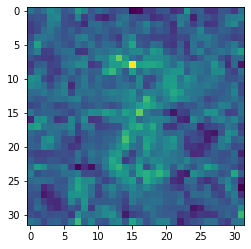

In [65]:
plt.imshow(x_train_noisy_rgb.numpy()[0, :, :, 0])

Use the predefined ResNet model:

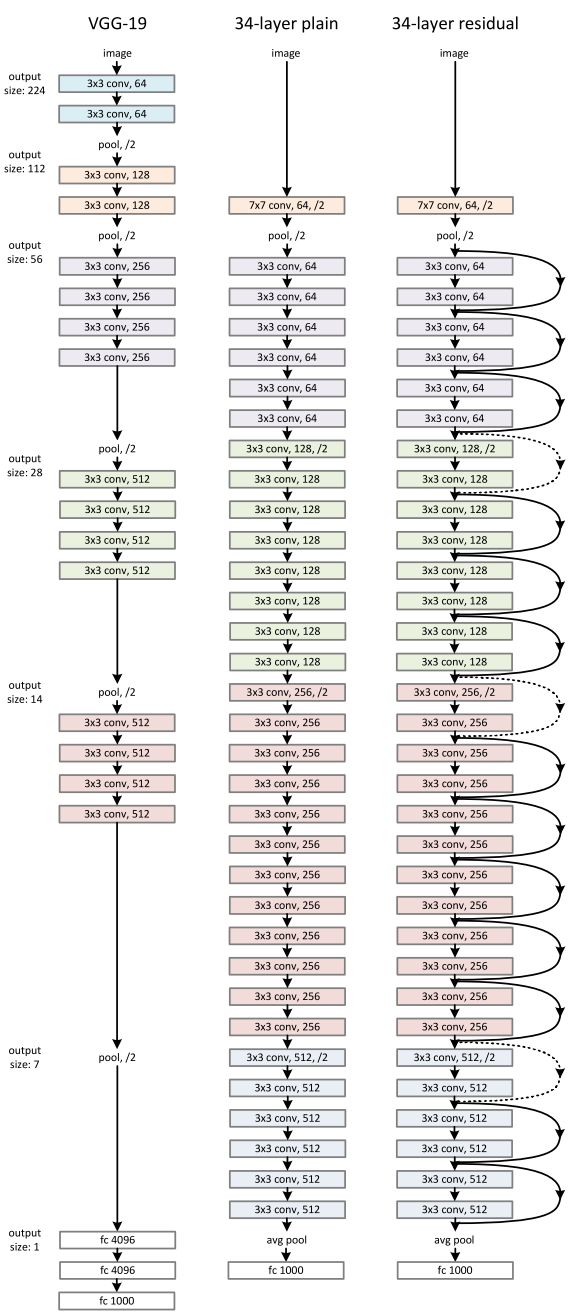

In [66]:
input = tf.keras.Input(shape=(32, 32, 3))
resnet = tf.keras.applications.ResNet50V2(weights=None,
                                          include_top=False, 
                                          input_tensor=input)

mid = tf.keras.layers.Reshape((2048,))(resnet.output)

output = tf.keras.layers.Dense(10, activation='softmax')(mid)

resnet_model = tf.keras.Model(resnet.input, output)

In [67]:
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 18, 18, 64)   0           ['conv1_conv[0][0]']             
                                                                                              

In [68]:
resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
resnet_model.fit(x_train_noisy_rgb, y_train, validation_data=(x_val_noisy_rgb, y_val), batch_size=256, epochs=10)

Epoch 1/10
196/196 [==============================] - 31s 111ms/step - loss: 1.0804 - accuracy: 0.6334 - val_loss: 0.8407 - val_accuracy: 0.7182
Epoch 2/10
196/196 [==============================] - 18s 93ms/step - loss: 0.5606 - accuracy: 0.8107 - val_loss: 0.5983 - val_accuracy: 0.8073
Epoch 3/10
196/196 [==============================] - 18s 94ms/step - loss: 0.4261 - accuracy: 0.8561 - val_loss: 0.6996 - val_accuracy: 0.7829
Epoch 4/10
196/196 [==============================] - 19s 97ms/step - loss: 0.3519 - accuracy: 0.8809 - val_loss: 0.6556 - val_accuracy: 0.7998
Epoch 5/10
196/196 [==============================] - 19s 95ms/step - loss: 0.2938 - accuracy: 0.8991 - val_loss: 0.6629 - val_accuracy: 0.8068
Epoch 6/10
196/196 [==============================] - 18s 94ms/step - loss: 0.2485 - accuracy: 0.9144 - val_loss: 0.6971 - val_accuracy: 0.8006
Epoch 7/10
196/196 [==============================] - 19s 99ms/step - loss: 0.2139 - accuracy: 0.9267 - val_loss: 0.7919 - val_accuracy

In [69]:
y_pred_noisy = resnet_model.predict(x_test_noisy_rgb)

313/313 [==============================] - 5s 10ms/step


In [70]:
y_pred_labels_noisy = np.argmax(y_pred_noisy, axis=1)

In [71]:
print('Accuracy: ', accuracy_score(y_true_labels, y_pred_labels_noisy))

Accuracy:  0.802


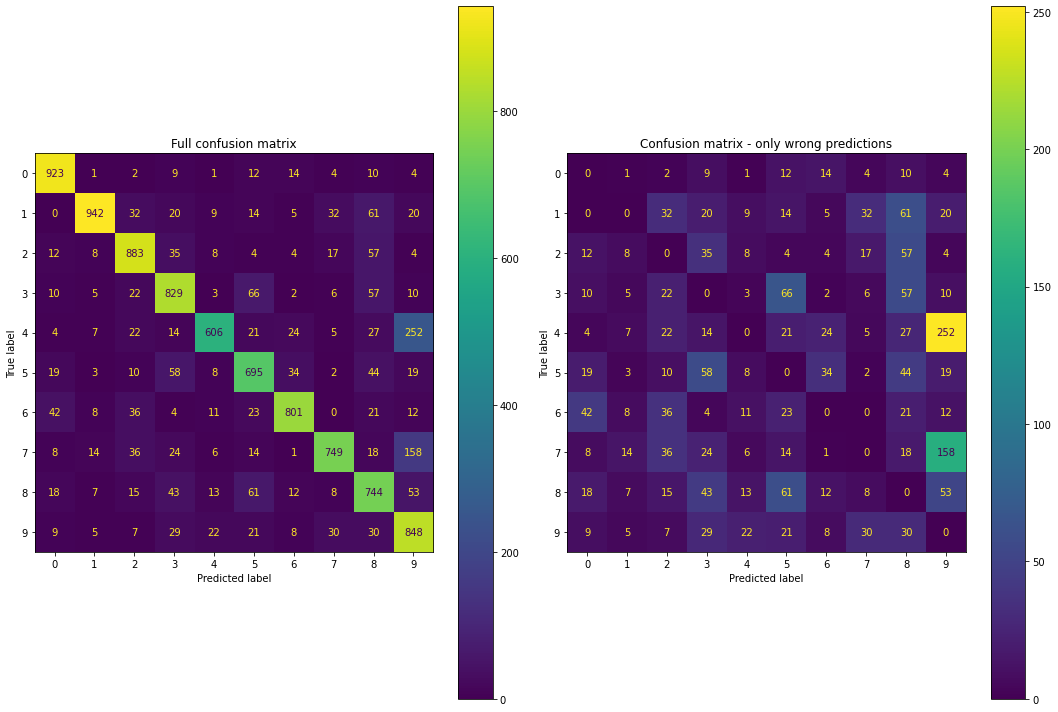

In [72]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

martix = confusion_matrix(y_true_labels, y_pred_labels_noisy)
ConfusionMatrixDisplay(martix).plot(ax=axes[0])
axes[0].title.set_text('Full confusion matrix')

np.fill_diagonal(martix, 0)
ConfusionMatrixDisplay(martix).plot(ax=axes[1])
axes[1].title.set_text('Confusion matrix - only wrong predictions')

plt.tight_layout()  
plt.show()

## Random Forest

In [73]:
x_train_noisy.shape, x_test_noisy.shape

((50000, 28, 28, 1), (10000, 28, 28, 1))

In [74]:
x_train_rf = np.zeros((x_train.shape[0], int(x_train.shape[1]**2)))
x_test_rf = np.zeros((x_test.shape[0], int(x_test.shape[1]**2)))

x_train_rf.shape, x_test_rf.shape

((50000, 784), (10000, 784))

In [75]:
for i in range(x_test_rf.shape[0]):
  x_test_rf[i, :] = x_test_noisy[i, :, :, 0].flatten()

In [76]:
for i in range(x_train_rf.shape[0]):
  x_train_rf[i, :] = x_train_noisy[i, :, :, 0].flatten()

In [77]:
x_train_rf[0, :].shape

(784,)

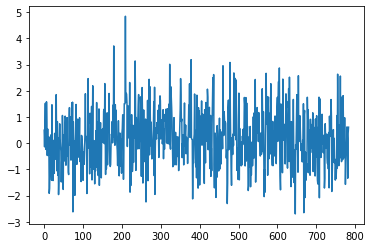

In [78]:
plt.plot(x_train_rf[0, :])

In [79]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42, 
                                n_jobs=-1, 
                                max_features=1/3)
rf_clf.fit(x_train_rf, np.argmax(y_train, axis=1))

RandomForestClassifier(max_features=0.3333333333333333, n_jobs=-1,
                       random_state=42)

In [80]:
y_pred_rf = rf_clf.predict(x_test_rf)

In [81]:
accuracy_score(np.argmax(y_test, axis=1), y_pred_rf)

0.4607

## Lower levels of noise

In [82]:
accuracies = []
for noise_level in range(100):
  y_pred_0 = conv_model.predict(x_test + noise_level * 0.01 * np.random.randn(*x_test.shape))
  y_pred_labels_0 = np.argmax(y_pred_0, axis=1)
  accuracies.append(accuracy_score(y_true_labels, y_pred_labels_0))

313/313 [==============================] - 1s 2ms/step


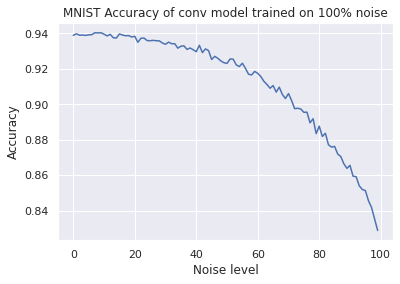

In [83]:
import seaborn as sns 
sns.set()

plt.title('MNIST Accuracy of conv model trained on 100% noise')
plt.plot([i for i in range(100)], accuracies)
plt.xlabel('Noise level')
plt.ylabel('Accuracy')
plt.show()

## Final thoughts

In today's demonstartion we saw how an exremely simple neural network can solve a somewhat complex problem. Without any hyperparemeter-tuning or complex covolutional architectures we managed to outperform classical ML methods. This is the power of neural networks.

We saw how noise can make a problem much more difficult. We saw how convolutions can capture spatial dependencies much better than FC. We also showed that random forest and tree-based algorithm perform rather poorly on images. Finally, we learned how to load a pre-defined model and re-train it.

Next week, we're going to cover even more complex problems in the domain of computer vision.